#Laboratorio 3 – Proyecto de Predicción de Predicción de Bicicletas

**Hellen Carranza**

In [1]:
import os
from six.moves import urllib
import pandas as pd
from zipfile import ZipFile
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
import pickle

DS_EXTRACT_PATH = "."
DS_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

def download_dataset(dataset_url=DS_URL, dataset_pc_path=DS_EXTRACT_PATH ):
    if not os.path.isdir(dataset_pc_path):
        os.makedirs(dataset_pc_path)
    parts = os.path.split(dataset_url)
    zipname = parts[-1]
    zip_path = os.path.join(dataset_pc_path, zipname)
    urllib.request.urlretrieve(dataset_url, zip_path)

def unzip_dataset(dataset_pc_path=DS_EXTRACT_PATH):
    zipname = os.path.join(dataset_pc_path, os.path.split(DS_URL)[-1])
    with ZipFile(zipname, 'r') as zip_ref:
        zip_ref.extractall(dataset_pc_path)
    os.remove(zipname)

def load_bike_hourly_data(bike_dataset_path=DS_EXTRACT_PATH):
    return pd.read_csv(os.path.join(bike_dataset_path, 'hour.csv'))


download_dataset()
unzip_dataset()

bikeshare = load_bike_hourly_data()


Primeras 48 filas del dataset:
    instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0         1  2011-01-01       1   0     1   0        0        6           0   
1         2  2011-01-01       1   0     1   1        0        6           0   
2         3  2011-01-01       1   0     1   2        0        6           0   
3         4  2011-01-01       1   0     1   3        0        6           0   
4         5  2011-01-01       1   0     1   4        0        6           0   
5         6  2011-01-01       1   0     1   5        0        6           0   
6         7  2011-01-01       1   0     1   6        0        6           0   
7         8  2011-01-01       1   0     1   7        0        6           0   
8         9  2011-01-01       1   0     1   8        0        6           0   
9        10  2011-01-01       1   0     1   9        0        6           0   
10       11  2011-01-01       1   0     1  10        0        6           0   
11       12  2011-01-

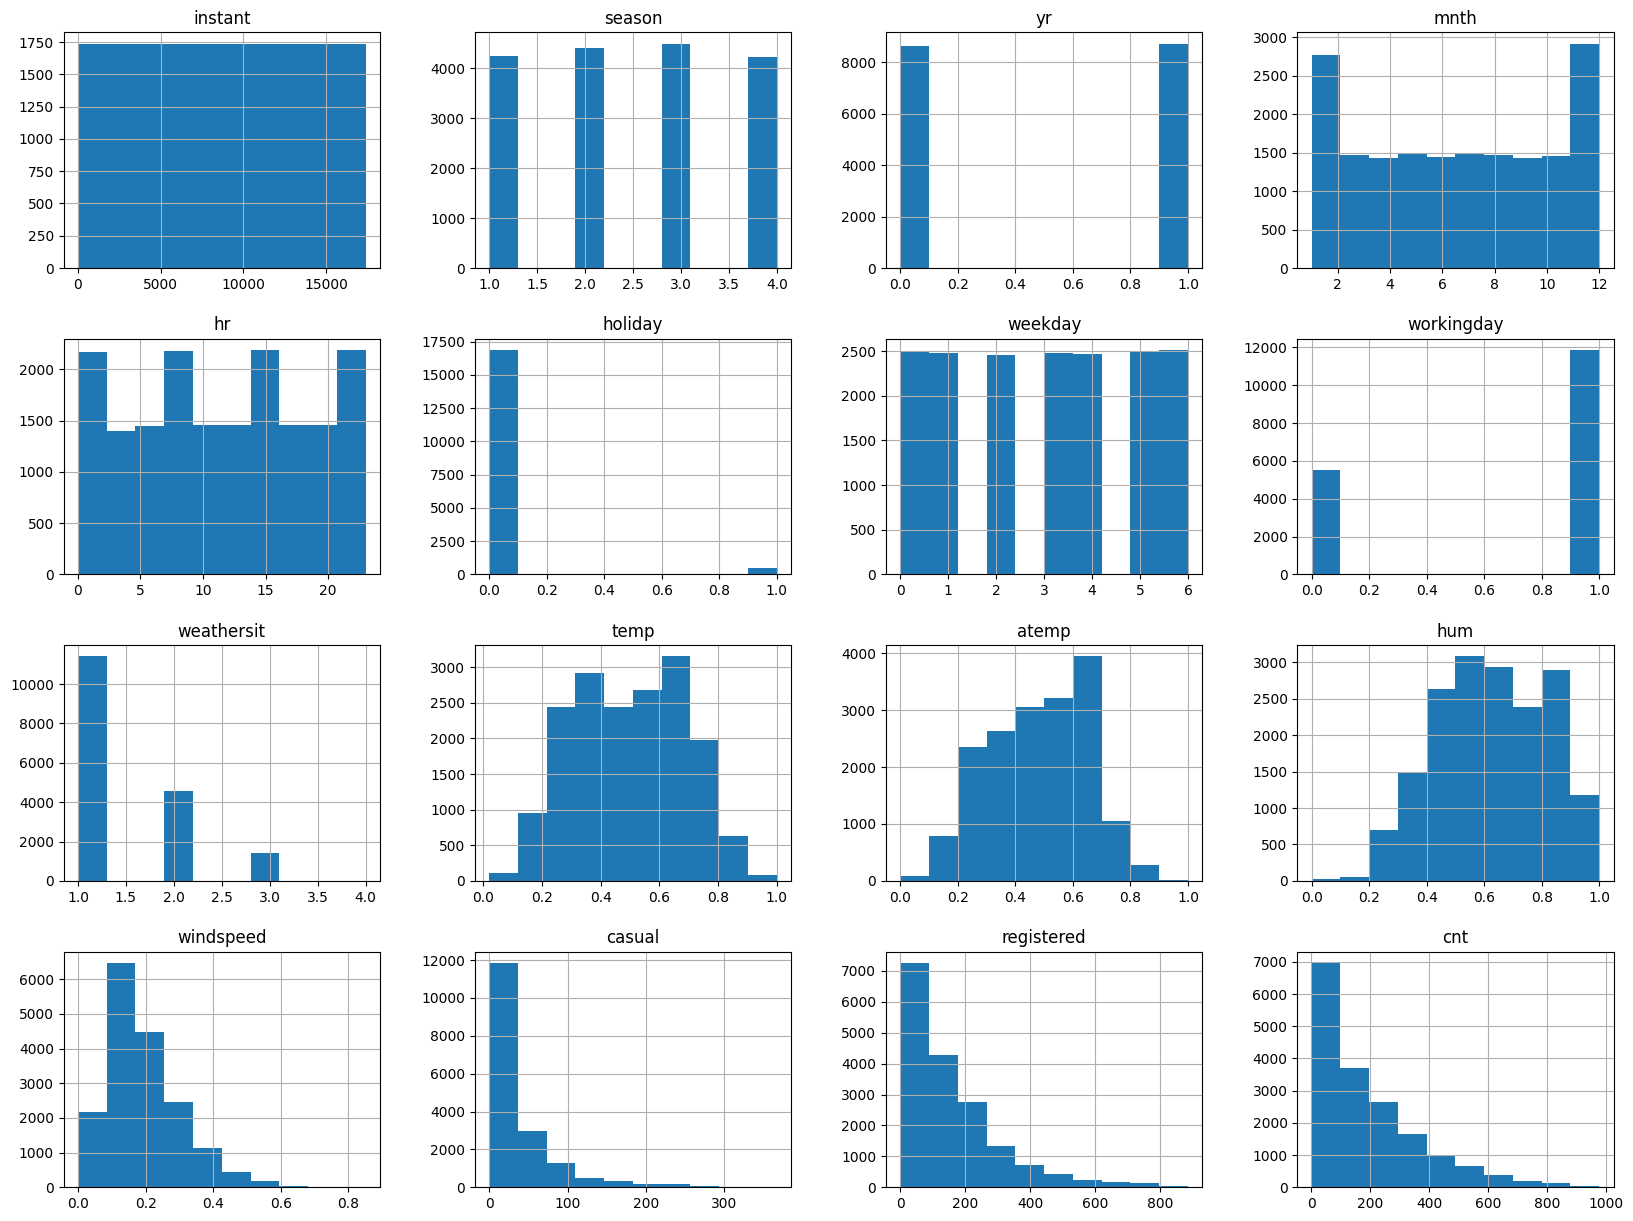

In [ ]:

print('Primeras 48 filas del dataset:')
print(bikeshare.head(48))


print('\nInformación esencial del dataset:')
bikeshare.info()


print('\nHistogramas de las variables numéricas:')
bikeshare.hist(figsize=(20, 15))
pyplot.show() 
pyplot.close()


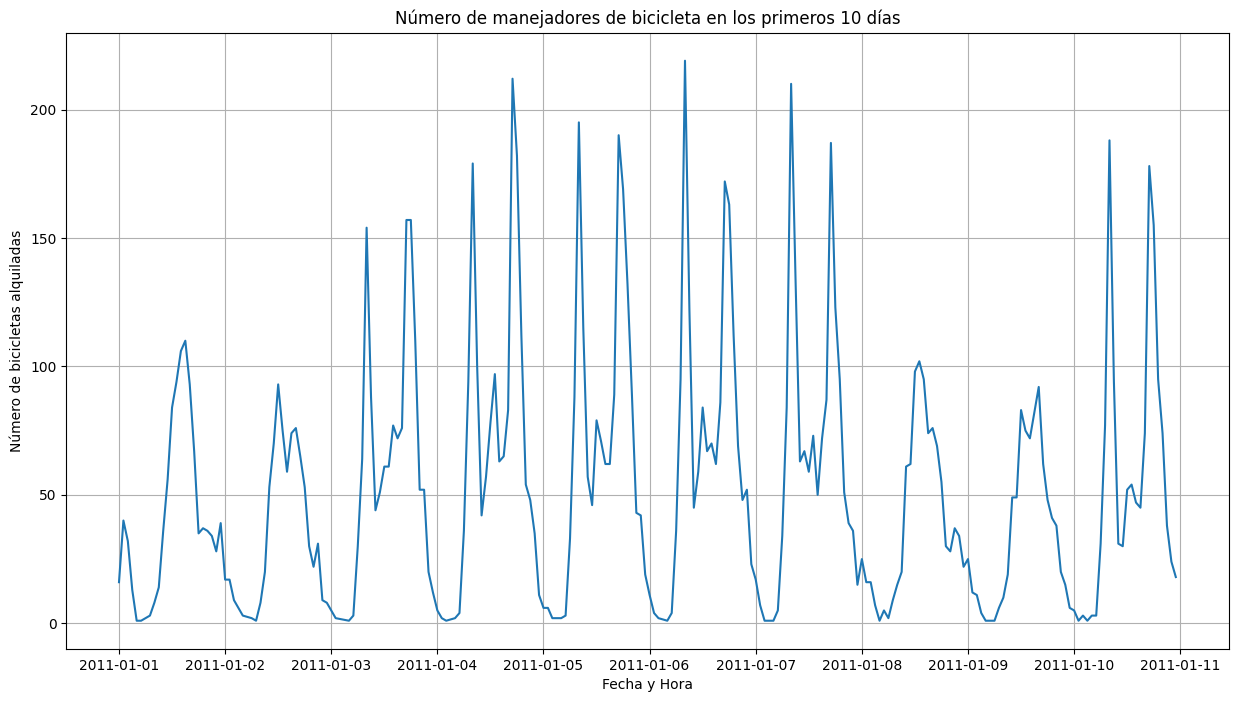

In [3]:

bikeshare['dteday'] = pd.to_datetime(bikeshare['dteday'])


first_10_days = bikeshare['dteday'].unique()[:10]


data_first_10_days = bikeshare[bikeshare['dteday'].isin(first_10_days)]


pyplot.figure(figsize=(15, 8))
pyplot.plot(data_first_10_days['dteday'] + pd.to_timedelta(data_first_10_days['hr'], unit='h'), data_first_10_days['cnt'])
pyplot.title('Número de manejadores de bicicleta en los primeros 10 días')
pyplot.xlabel('Fecha y Hora')
pyplot.ylabel('Número de bicicletas alquiladas')
pyplot.grid(True)
pyplot.show()
pyplot.close()


In [4]:
# Variables Dummy - Transformación de Data Categórica
dummy_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_cols:
    dummies = pd.get_dummies(bikeshare[each], prefix=each, drop_first=False)
    bikeshare = pd.concat([bikeshare, dummies], axis=1)

drop_cols = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = bikeshare.drop(drop_cols, axis=1)
print('\nDataset después de la transformación de variables dummy:')
print(data.head())



Dataset después de la transformación de variables dummy:
   yr  holiday  temp   hum  windspeed  casual  registered  cnt  season_1  \
0   0        0  0.24  0.81        0.0       3          13   16      True   
1   0        0  0.22  0.80        0.0       8          32   40      True   
2   0        0  0.22  0.80        0.0       5          27   32      True   
3   0        0  0.24  0.75        0.0       3          10   13      True   
4   0        0  0.24  0.75        0.0       0           1    1      True   

   season_2  ...  hr_21  hr_22  hr_23  weekday_0  weekday_1  weekday_2  \
0     False  ...  False  False  False      False      False      False   
1     False  ...  False  False  False      False      False      False   
2     False  ...  False  False  False      False      False      False   
3     False  ...  False  False  False      False      False      False   
4     False  ...  False  False  False      False      False      False   

   weekday_3  weekday_4  weekday_5  week

In [5]:
# Escalar el Dataset
to_scale = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for each in to_scale:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
print('\nDataset después del escalado de variables:')
print(data.head())



Dataset después del escalado de variables:
   yr  holiday      temp       hum  windspeed    casual  registered       cnt  \
0   0        0 -1.334609  0.947345  -1.553844 -0.662736   -0.930162 -0.956312   
1   0        0 -1.438475  0.895513  -1.553844 -0.561326   -0.804632 -0.823998   
2   0        0 -1.438475  0.895513  -1.553844 -0.622172   -0.837666 -0.868103   
3   0        0 -1.334609  0.636351  -1.553844 -0.662736   -0.949983 -0.972851   
4   0        0 -1.334609  0.636351  -1.553844 -0.723582   -1.009445 -1.039008   

   season_1  season_2  ...  hr_21  hr_22  hr_23  weekday_0  weekday_1  \
0      True     False  ...  False  False  False      False      False   
1      True     False  ...  False  False  False      False      False   
2      True     False  ...  False  False  False      False      False   
3      True     False  ...  False  False  False      False      False   
4      True     False  ...  False  False  False      False      False   

   weekday_2  weekday_3  weekd

/tmp/ipython-input-5-659710970.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.662736   -0.56132647 -0.62217218 ... -0.58160837 -0.45991693
 -0.48019884]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, each] = (data[each] - mean)/std
/tmp/ipython-input-5-659710970.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.93016249 -0.80463169 -0.83766611 ... -0.46768062 -0.69892155
 -0.77159727]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, each] = (data[each] - mean)/std
/tmp/ipython-input-5-659710970.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.95631172 -0.82399838 -0.86810283 ... -0.54834558 -0.7082242
 -0.77438087]' has dtype incompatible with in

In [6]:
# Separación del Dataset
target_fields = ['cnt', 'casual', 'registered']
X = data.drop(target_fields, axis=1)
y = data['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = neighbors.KNeighborsRegressor(n_neighbors=4, n_jobs=4)
model.fit(X_train, y_train)


model_filename = 'bike_rental_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
print(f'\nModelo guardado en: {model_filename}')


with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
print(f'\nModelo cargado desde: {model_filename}')



Modelo guardado en: bike_rental_model.pkl

Modelo cargado desde: bike_rental_model.pkl



Error Cuadrático Medio (MSE): 0.3302906471149848


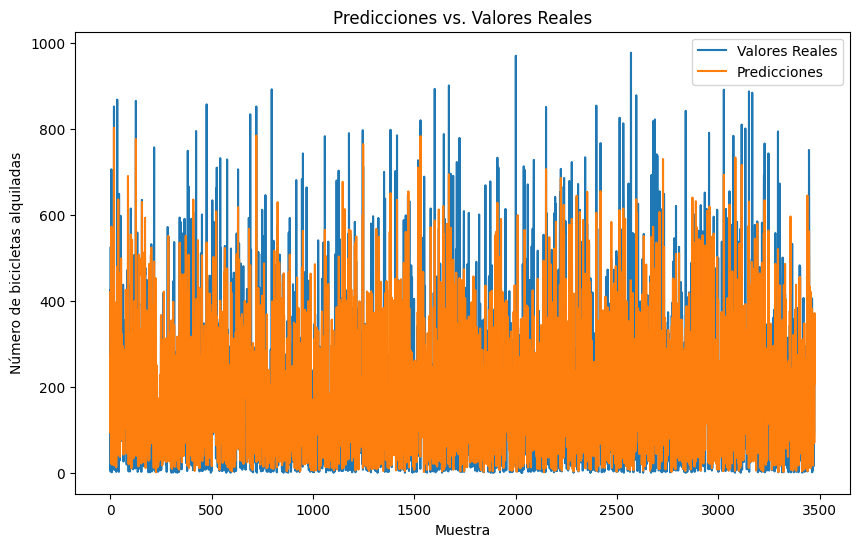

In [7]:
#Predicciones
predictions = loaded_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'\nError Cuadrático Medio (MSE): {mse}')


mean_cnt, std_cnt = scaled_features['cnt']
y_test_unscaled = y_test * std_cnt + mean_cnt
predictions_unscaled = predictions * std_cnt + mean_cnt

fig, ax = pyplot.subplots(figsize=(10, 6))
ax.plot(y_test_unscaled.values, label='Valores Reales')
ax.plot(predictions_unscaled, label='Predicciones')
ax.set_title('Predicciones vs. Valores Reales')
ax.set_xlabel('Muestra')
ax.set_ylabel('Número de bicicletas alquiladas')
ax.legend()
pyplot.show()
pyplot.close()
